In [409]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [410]:
import string

base_path = '/home/flok3n/develop/k8s_inc_analysis/eval/tcp'
def save_fig(name: str, fig=None):
    if fig is None:
        fig = plt.gcf()
    fig.tight_layout(w_pad=3.5)
    fig.subplots_adjust(top=0.88)
    fig.savefig(f'{base_path}/{name}.svg')

def annotate(axs):
    axs[0].text(-0.1, 0.95, f'{string.ascii_lowercase[0]}', transform=axs[0].transAxes, size=18, weight='bold')
    axs[1].text(-0.1, 0.95, f'{string.ascii_lowercase[1]}', transform=axs[1].transAxes, size=18, weight='bold')

In [411]:
collector_df = pd.read_csv('../data/new_http_tcp3/reports.csv')
sender_df = pd.read_csv('../data/new_http_tcp3/latency_http.csv')
# t = (164, 180)

# flow_start_timestamps = [
#     1716137072023787559,
#     1716137116382696201,
#     1716137144622187949,
#     1716137206155300972,
#     1716137232641267087
# ]


flow_start_timestamps = [
    1716138961883385899,
    1716139014259317388,
    1716139040513427698,
    1716139064937925411,
    1716139095978277805
]

sender_df.columns = ['timestamp', 'latency', 'dropped']

sender_df['latency'] = sender_df['latency'].apply(lambda x: int(x * 1000))
collector_df['hop_latency'] = collector_df['hop_latency'].apply(lambda x: int(x / 1000))
collector_df['ingress_timestamp'] = collector_df['ingress_timestamp'].apply(lambda x: float(x) / 1e9)
collector_df['egress_timestamp'] = collector_df['egress_timestamp'].apply(lambda x: float(x) / 1e9)
sender_start = sender_df.iloc[0]['timestamp']
collector_start = collector_df.iloc[0]['collector_timestamp']
collector_ingress_start = collector_df.iloc[0]['ingress_timestamp']
start = min(sender_start, collector_start, collector_ingress_start)

collector_df['collector_timestamp'] -= start
sender_df['timestamp'] -= start
collector_df['ingress_timestamp'] -= start
collector_df['egress_timestamp'] -= start

for i, x in enumerate(flow_start_timestamps):
    flow_start_timestamps[i] = (float(x) / 1e9) - start
    print(flow_start_timestamps[i])

t = (34.5, 46.5, flow_start_timestamps[0])
# t = (86.87, 96.87, flow_start_timestamps[1])
# t = (113.1, 123.1, flow_start_timestamps[2])
t4 = (137.5, 147.5, flow_start_timestamps[3])
t5 = (168.5, 180.5, flow_start_timestamps[4])

36.50267553329468
88.87860703468323
115.13271737098694
139.55721497535706
170.59756755828857


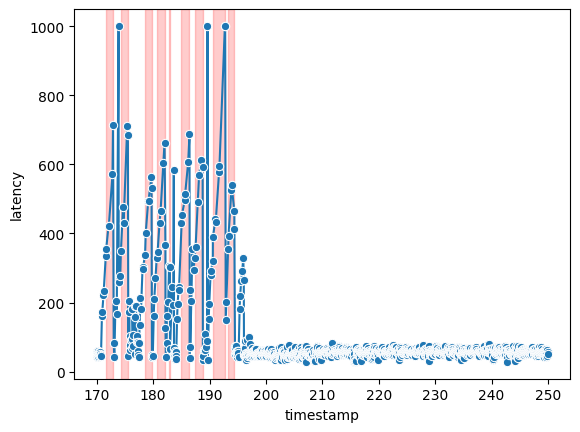

In [412]:
def compute_qos_violation_time_ranges(sender_df: pd.DataFrame, violation_threshold=400) -> list[tuple[float, float]]:
    violation_ranges = []
    start = None
    for i in range(len(sender_df)):
        is_violation = sender_df.iloc[i]['latency'] > violation_threshold
        if is_violation and start is None:
            start = i
        elif not is_violation and start is not None:
            if i - start > 1:
                violation_ranges.append([sender_df.iloc[start]['timestamp'], sender_df.iloc[i - 1]['timestamp']])
            start = None
    if start is not None and start < len(sender_df) - 1:
        violation_ranges.append([sender_df.iloc[start]['timestamp'], sender_df.iloc[len(sender_df) - 1]['timestamp']])

    return violation_ranges

def display_qos_violations(violation_ranges: list[tuple[float, float]], ax, delay=0, padding=0):
    for start, end in violation_ranges: 
        start = start - delay - padding
        end = end - delay + padding
        ax.axvspan(start, end, color='red', alpha=0.2)
    
def _test_show_qos_violations(sender_df: pd.DataFrame, collector_df: pd.DataFrame, violation_threshold=400, collector_x='collector_timestamp'):
    sdf = sender_df.copy()
    fig, ax = plt.subplots(1, 1)
    sns.lineplot(data=sdf, x='timestamp', y='latency', marker='o', ax=ax)
    violation_ranges = compute_qos_violation_time_ranges(sender_df, violation_threshold=300)
    display_qos_violations(violation_ranges, ax)

_test_show_qos_violations(sender_df[(sender_df['timestamp'] > 170) & (sender_df['timestamp'] < 250)], collector_df)

<Axes: xlabel='collector_timestamp', ylabel='hop_latency'>

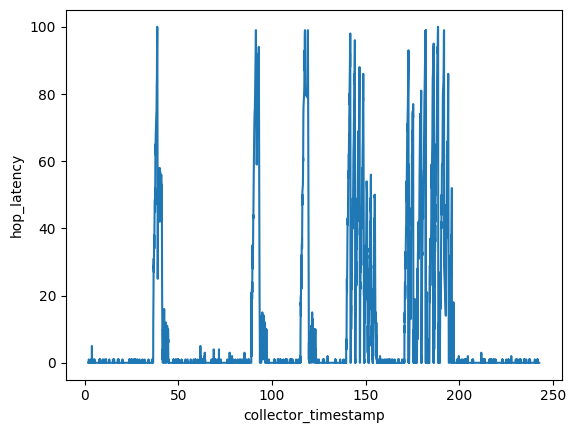

In [413]:
sns.lineplot(data=collector_df[(collector_df['switch_id']==1) & (collector_df['l1_egress_port_id']==3)], x='collector_timestamp', y='hop_latency')

<Axes: xlabel='collector_timestamp', ylabel='queue_occupancy'>

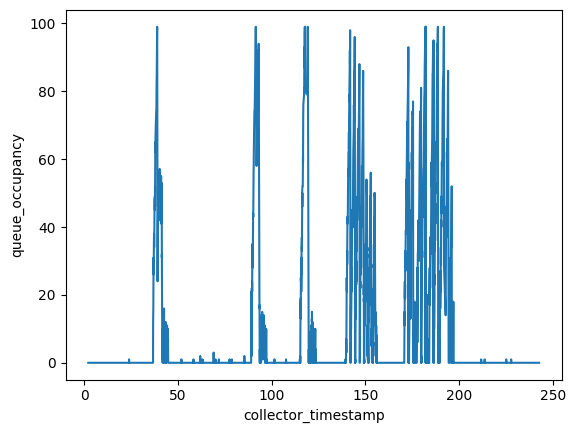

In [414]:
sns.lineplot(data=collector_df[(collector_df['switch_id']==1) & (collector_df['l1_egress_port_id']==3)], x='collector_timestamp', y='queue_occupancy')

<Axes: xlabel='timestamp', ylabel='latency'>

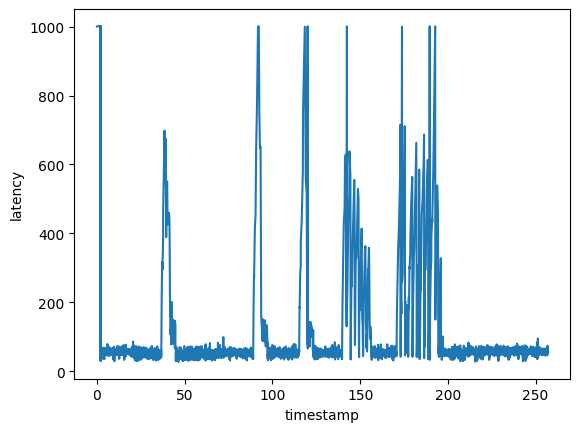

In [415]:
sns.lineplot(data=sender_df, x='timestamp', y='latency')

In [416]:

switch_name_to_id = {"r7": 1, "r2": 2, "r10": 3, "r9": 5, "r3": 6, "r6": 9, "r1": 0, "r8": 4, "r4": 7, "r5": 8}
switch_id_to_name = {v: k for k, v in switch_name_to_id.items() if k in ['r1', 'r7', 'r3', 'r5', 'r9']}
print(switch_id_to_name)

port_map = {
    "0_1": "s1-s7",
    "0_2": "s1-w1",
    "0_3": "s1-w2",
    "1_0": "s7-s1",
    "1_1": "s7-s2",
    "1_3": "s7-s10",
    "6_1": "s3-s8",
    "6_2": "s3-w5",
    "6_3": "s3-w6",
    "8_1": "s5-s9",
    "8_2": "s5-w9",
    "8_3": "s5-w10",
    "5_1": "s9-s5",
    "5_2": "s9-s6",
    "5_3": "s9-s10",
}

{1: 'r7', 5: 'r9', 6: 'r3', 0: 'r1', 8: 'r5'}


In [417]:
collector_df['port_key'] = collector_df.apply(lambda row: port_map[f'{row["switch_id"]}_{row["l1_egress_port_id"]}'], axis=1)

In [418]:
collector_df['port_key'].unique()

array(['s1-s7', 's7-s10', 's1-w2', 's9-s6', 's5-s9', 's9-s5', 's7-s2',
       's1-w1', 's3-s8'], dtype=object)

<Axes: xlabel='collector_timestamp', ylabel='hop_latency'>

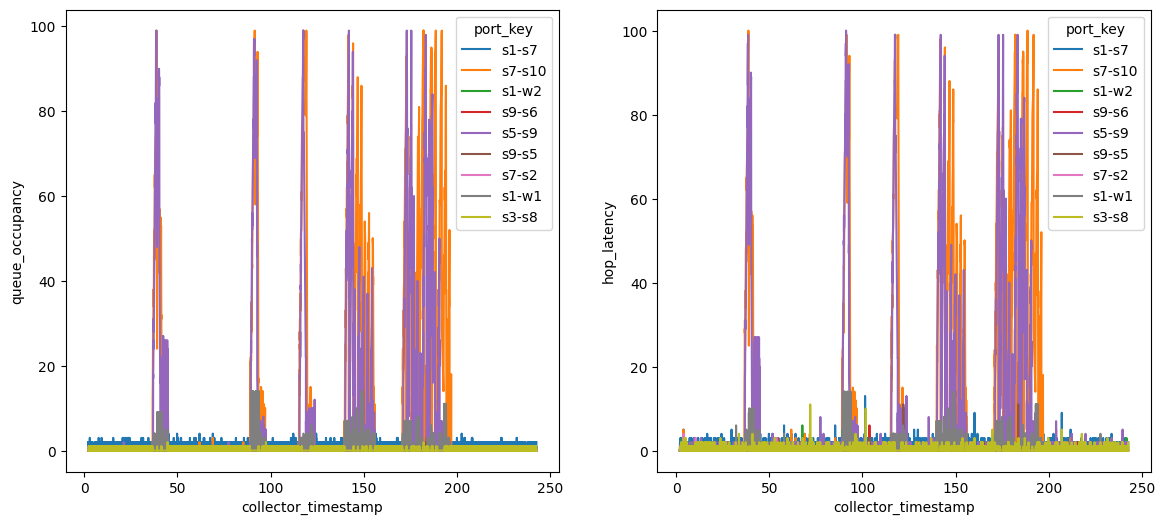

In [419]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.lineplot(ax=ax[0], data=collector_df, x='collector_timestamp', y='queue_occupancy', hue='port_key', legend=True, estimator=None, n_boot=0)
sns.lineplot(ax=ax[1], data=collector_df, x='collector_timestamp', y='hop_latency', hue='port_key', legend=True, estimator=None, n_boot=0)

<Axes: xlabel='collector_timestamp', ylabel='hop_latency'>

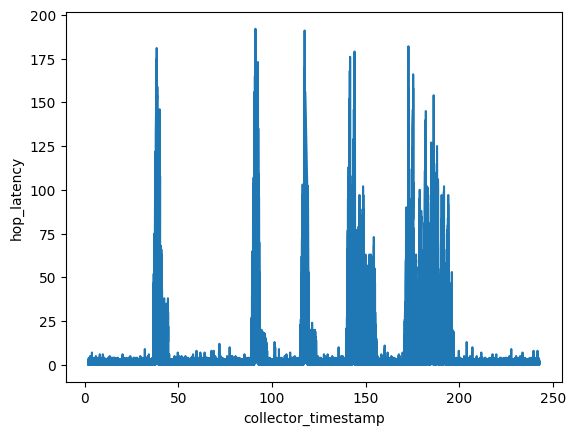

In [420]:
grouped_df = collector_df.groupby(by='flow_id').agg({'hop_latency': 'sum', 'collector_timestamp': 'first'})
sns.lineplot(data=grouped_df, x='collector_timestamp', y='hop_latency')


In [421]:
def sub_dfs(sender_df: pd.DataFrame, collector_df: pd.DataFrame, t) -> tuple[pd.DataFrame, pd.DataFrame, float]:
    dfs = []
    for df in (sender_df, collector_df):
        col_name = 'timestamp'
        if col_name not in df.columns:
            col_name = 'collector_timestamp'
        sdf = df[(df[col_name] > t[0]) & (df[col_name] < t[1])].copy()
        dfs.append(sdf)
    sender_df, collector_df = dfs
    start = min(sender_df.iloc[0]['timestamp'], collector_df.iloc[0]['collector_timestamp'], collector_df.iloc[0]['ingress_timestamp'])
    sender_df['timestamp'] -= start
    collector_df['collector_timestamp'] -= start
    collector_df['ingress_timestamp'] -= start
    collector_df['egress_timestamp'] -= start
    return sender_df, collector_df, t[2] - start, start

In [422]:
sub_sdf, sub_cdf, elephant_start, cur_experiment_start = sub_dfs(sender_df, collector_df, t)

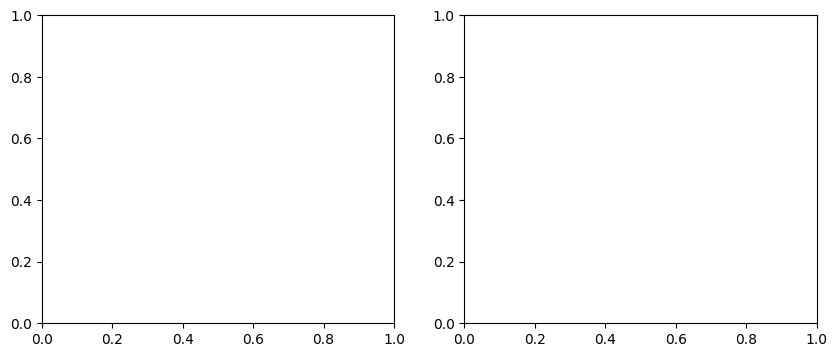

In [423]:
violation_ranges = compute_qos_violation_time_ranges(sub_sdf, violation_threshold=200)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# sns.lineplot(data=sub_sdf, x='timestamp', y='latency', ax=ax[0], marker='o', markersize=3)
# ax[0].set_xlabel("Time [s]")
# ax[0].set_ylabel("Latency [ms]")
# ax[0].axvline(elephant_start, color='red', linestyle='--', linewidth=2)
# # ax.axvline(elephant_start+8.2, color='red', linestyle='--', linewidth=2)
# ax[0].axhline(200, color='green', alpha=0.7, linestyle='--', linewidth=1)
# event_patch = mpatches.Patch(color='red', alpha=0.2, label='QoS violation time span')
# # Custom legend for the dashed green vertical line
# start_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Start of elephant flow')
# violation_thresh_line = mlines.Line2D([], [], color='green', alpha=0.7, linestyle='--', linewidth=1, label='QoS violation threshold')

# # Add the legend to the plot
# ax[0].legend(handles=[start_line, event_patch, violation_thresh_line], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

# display_qos_violations(violation_ranges, ax[0])

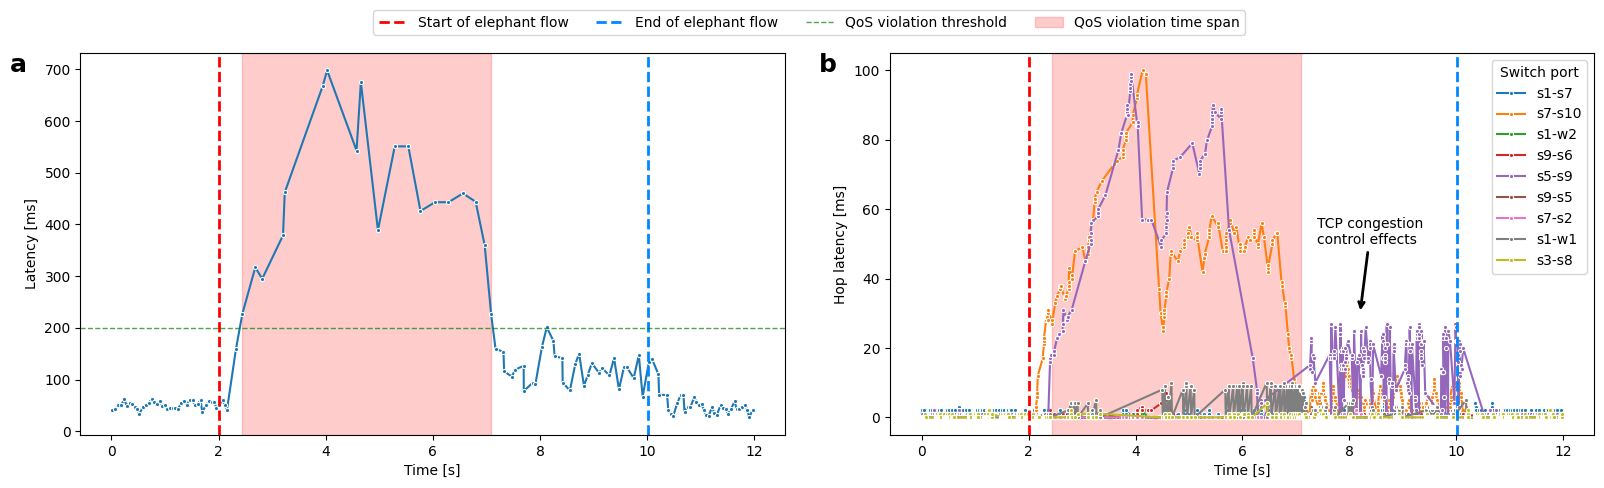

In [424]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
N = len(collector_df)
sns.lineplot(data=sub_sdf, x='timestamp', y='latency', ax=ax[0], marker='o', markersize=3)
sns.lineplot(ax=ax[1], data=sub_cdf, x='ingress_timestamp', y='hop_latency', hue='port_key', legend=True, estimator=None, n_boot=0, marker='o', markersize=3)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Latency [ms]")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Hop latency [ms]")
ax[1].legend_.set_title("Switch port")
display_qos_violations(violation_ranges, ax[0], padding=0)
display_qos_violations(violation_ranges, ax[1], padding=0)

for a in ax:
    a.axvline(elephant_start, color='red', linestyle='--', linewidth=2)
    a.axvline(elephant_start+8, color='#0088ff', linestyle='--', linewidth=2)
ax[0].axhline(200, color='green', alpha=0.7, linestyle='--', linewidth=1)
event_patch = mpatches.Patch(color='red', alpha=0.2, label='QoS violation time span')
# Custom legend for the dashed green vertical line
# start_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Start of varying elephant flow')
start_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Start of elephant flow')
end_line = mlines.Line2D([], [], color='#0088ff', linestyle='--', linewidth=2, label='End of elephant flow')
violation_thresh_line = mlines.Line2D([], [], color='green', alpha=0.7, linestyle='--', linewidth=1, label='QoS violation threshold')

ax[1].annotate('TCP congestion\ncontrol effects', xy=(8.2, 30), xytext=(7.4, 50),
            arrowprops=dict(facecolor='black', arrowstyle='->', lw=2))

# Place the combined legend in the middle
fig.legend(handles=[start_line, end_line, violation_thresh_line, event_patch], loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=4)
annotate(ax)
save_fig('scenario_1_combined', fig)

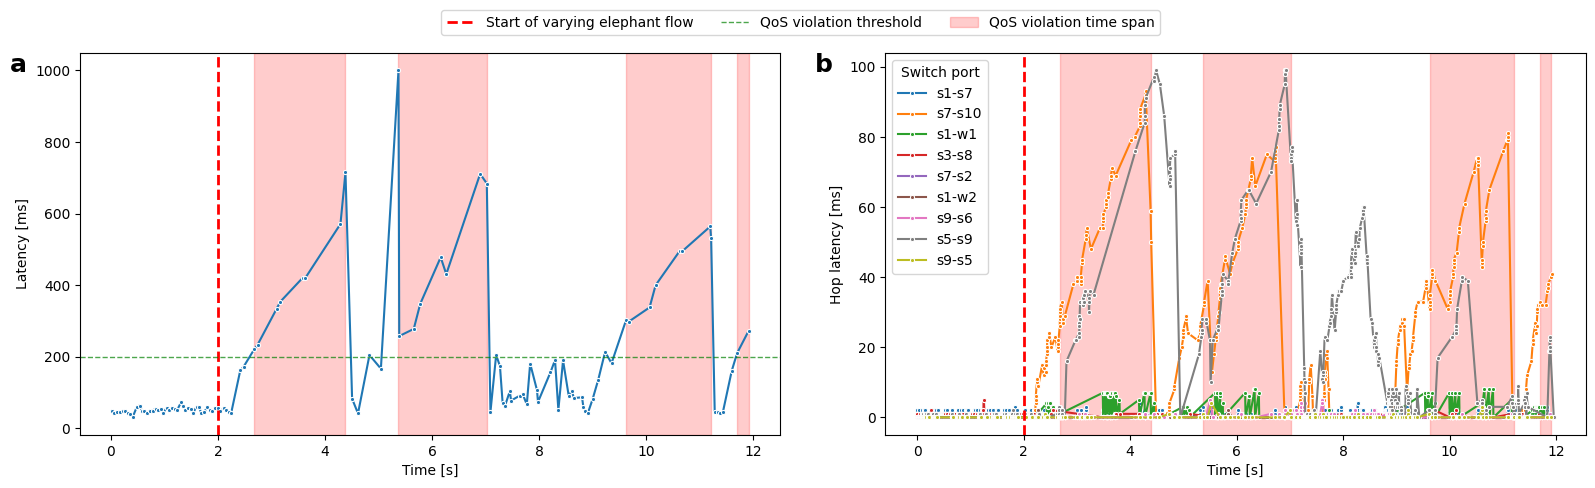

In [425]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sub_sdf2, sub_cdf2, elephant_start2, cur_experiment_start2 = sub_dfs(sender_df, collector_df, t5)
violation_ranges2 = compute_qos_violation_time_ranges(sub_sdf2, violation_threshold=200)
N = len(collector_df)
sns.lineplot(data=sub_sdf2, x='timestamp', y='latency', ax=ax[0], marker='o', markersize=3)
sns.lineplot(ax=ax[1], data=sub_cdf2, x='ingress_timestamp', y='hop_latency', hue='port_key', legend=True, estimator=None, n_boot=0, marker='o', markersize=3)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Latency [ms]")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Hop latency [ms]")
ax[1].legend_.set_title("Switch port")
display_qos_violations(violation_ranges2, ax[0], padding=0)
display_qos_violations(violation_ranges2, ax[1], padding=0)

for a in ax:
    a.axvline(elephant_start, color='red', linestyle='--', linewidth=2)
ax[0].axhline(200, color='green', alpha=0.7, linestyle='--', linewidth=1)
event_patch = mpatches.Patch(color='red', alpha=0.2, label='QoS violation time span')
# Custom legend for the dashed green vertical line
start_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Start of varying elephant flow')
violation_thresh_line = mlines.Line2D([], [], color='green', alpha=0.7, linestyle='--', linewidth=1, label='QoS violation threshold')

# Place the combined legend in the middle
fig.legend(handles=[start_line, violation_thresh_line, event_patch], loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3)
annotate(ax)
save_fig('scenario_5_combined_tcp', fig)

<Axes: xlabel='timestamp', ylabel='dropped'>

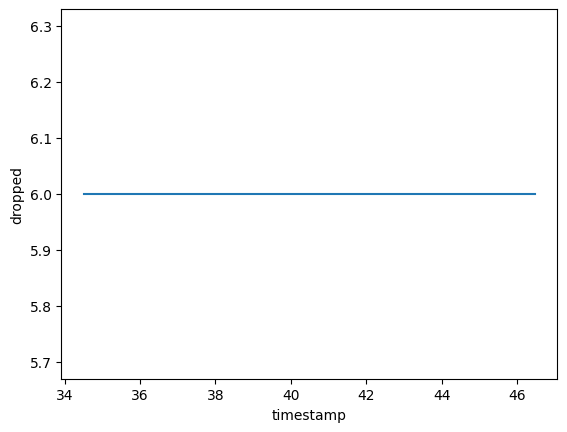

In [426]:
sns.lineplot(data=sender_df[(sender_df['timestamp'] > t[0]) & (sender_df['timestamp'] < t[1])], x='timestamp', y='dropped')

In [427]:
port_key_map_v2 = {
    'r1_r7': 's1-s7',
    'r1_tree-worker2': 's1-w1',
    'r1_tree-worker11': 's1-w2',
    'r7_r1': 's7-s1',
    'r7_r10': 's7-s10',
    'r9_r10': 's9-s10',
    'r9_r5': 's9-s5',
    'r3_r8': 's3-s8',
    'r5_r9': 's5-s9'
}

In [428]:
cols = ['timestamp', 'averagePathLatency', 'onePercentileSlowestPathLatency', 'port_key', 'averageLatency',
        'onePercentileSlowestLatency', 'onePercentileLargestQueueFillState', 'averageQueueFillState', 'packets']
rows = []
import json
max_i = 1862
for i in range(max_i+1):
    with open(f'./../data/new_http_tcp3/logs{i}.json', 'r') as f:
        data = json.load(f)
        base_row = [
            data['createdAt'] - start,
            data['windowMetrics']['averagePathLatencyMicroS'] / 1000,
            data['windowMetrics']['onePercentileSlowestPathLatencyMicroS'] / 1000,
        ]
        for dm in data['windowMetrics']['deviceMetrics']:
            for pm in dm['portMetrics']:
                row = [*base_row]
                port_key = port_key_map_v2[f'{dm["deviceName"]}_{pm["toDevice"]}']
                row.extend([
                    port_key,
                    pm['averageLatencyMicroS'] / 1000,
                    pm['onePercentileSlowestLatencyMicroS'] / 1000,
                    pm['onePercentileLargestQueueFillState'],
                    pm['averageQueueFillState'],
                    pm['packets'],
                ])
                rows.append(row)

summary_df = pd.DataFrame.from_records(rows, columns=cols)
summary_df.head()

,timestamp,averagePathLatency,onePercentileSlowestPathLatency,port_key,averageLatency,onePercentileSlowestLatency,onePercentileLargestQueueFillState,averageQueueFillState,packets
0,21.61929,4.03,7.916,s1-s7,0.688,2.761,2,0,1367
1,21.61929,4.03,7.916,s1-w1,0.339,0.890,0,0,534
2,21.61929,4.03,7.916,s1-w2,0.313,0.844,0,0,420
3,21.61929,4.03,7.916,s7-s1,0.295,0.910,0,0,490
4,21.61929,4.03,7.916,s7-s10,0.400,0.957,0,0,687


In [429]:
def sub_summary_df(summary_df: pd.DataFrame, t, t0) -> pd.DataFrame:
    sdf = summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1])].copy()
    sdf['timestamp'] -= t0
    return sdf

<Axes: xlabel='timestamp', ylabel='onePercentileSlowestPathLatency'>

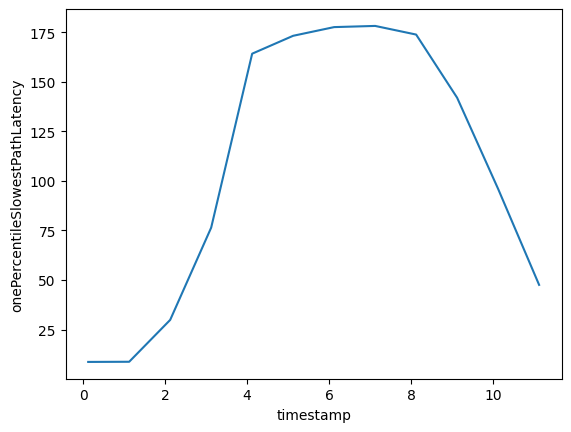

In [430]:
sns.lineplot(data=sub_summary_df(summary_df, t, cur_experiment_start), x='timestamp', y='onePercentileSlowestPathLatency', errorbar=None)

In [431]:
summary_df['port_key'].unique()

array(['s1-s7', 's1-w1', 's1-w2', 's7-s1', 's7-s10', 's9-s10', 's9-s5',
       's3-s8', 's5-s9'], dtype=object)

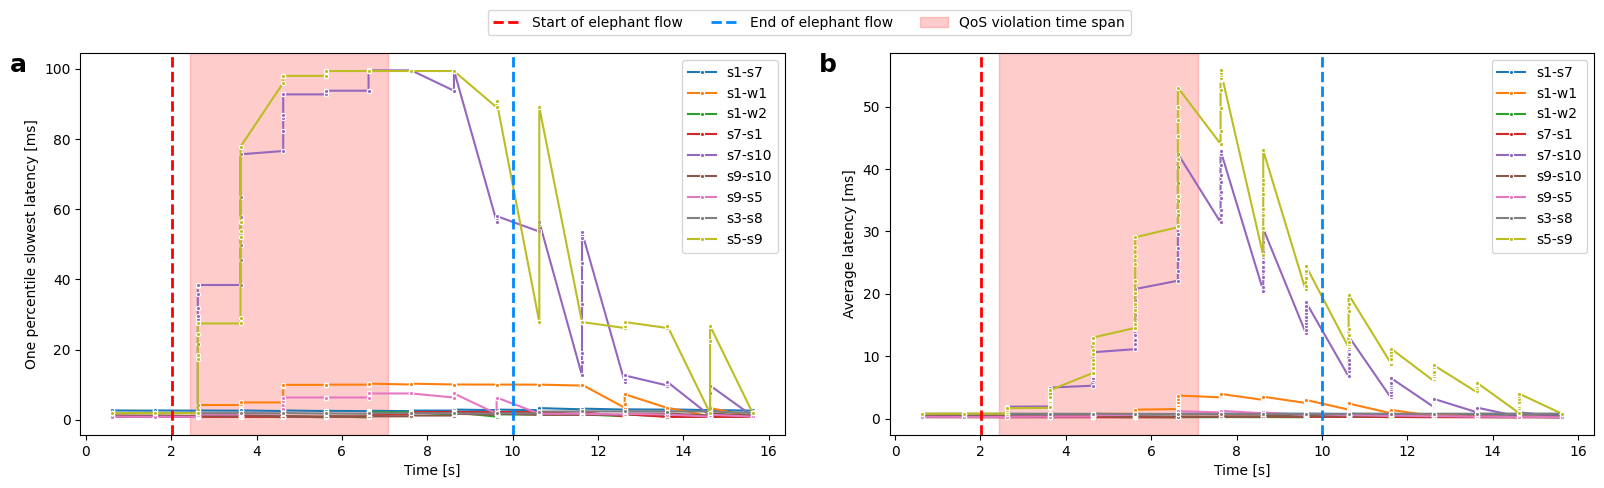

In [432]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
N = len(collector_df)
sd2 = summary_df.copy()
sd2['timestamp'] += 0.5
sns.lineplot(ax=ax[0], data=sub_summary_df(sd2, [t[0], t[1] + 4], cur_experiment_start), x='timestamp', y='onePercentileSlowestLatency', hue='port_key', legend=True, estimator=None, n_boot=0, marker='o', markersize=3)
sns.lineplot(ax=ax[1], data=sub_summary_df(sd2, [t[0], t[1] + 4], cur_experiment_start), x='timestamp', y='averageLatency', hue='port_key', legend=True, estimator=None, n_boot=0, marker='o', markersize=3)
sns.move_legend(ax[0], "upper left")
sns.move_legend(ax[1], "upper left")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("One percentile slowest latency [ms]")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Average latency [ms]")
for a in ax:
    a.legend_.set_title("Switch port")
display_qos_violations(violation_ranges, ax[0], padding=0)
display_qos_violations(violation_ranges, ax[1], padding=0)

for a in ax:
    a.axvline(elephant_start, color='red', linestyle='--', linewidth=2)
    a.axvline(elephant_start+8, color='#0088ff', linestyle='--', linewidth=2)
    a.legend(loc='upper right')
event_patch = mpatches.Patch(color='red', alpha=0.2, label='QoS violation time span')
# Custom legend for the dashed green vertical line
start_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Start of elephant flow')
end_line = mlines.Line2D([], [], color='#0088ff', linestyle='--', linewidth=2, label='End of elephant flow')

# Place the combined legend in the middle
fig.legend(handles=[start_line, end_line, event_patch], loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3)
annotate(ax)
save_fig('scenario_1_k8s_latency_tcp', fig)

<Axes: xlabel='timestamp', ylabel='averageQueueFillState'>

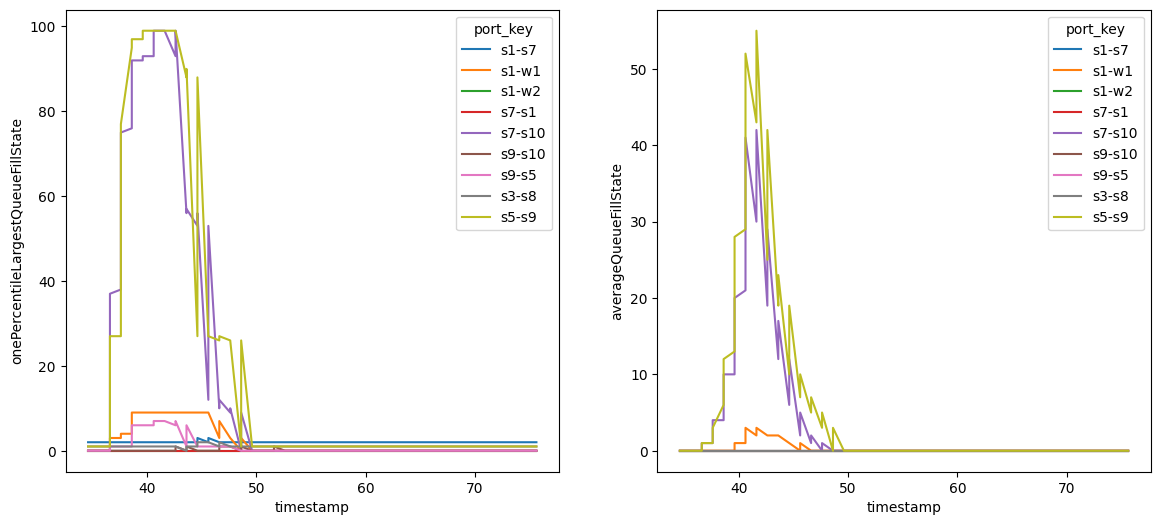

In [433]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
N = len(collector_df)
sns.lineplot(ax=ax[0], data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1] + 30)], x='timestamp', y='onePercentileLargestQueueFillState', hue='port_key', legend=True, estimator=None, n_boot=0)
sns.lineplot(ax=ax[1], data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1] + 30)], x='timestamp', y='averageQueueFillState', hue='port_key', legend=True, estimator=None, n_boot=0)